# REGRESSION

In [1]:
import statsmodels.formula.api as smf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
sns.set_style('darkgrid')

## HELPER FUNCTIONS

In [2]:
def create_regressor_columns_string(columns):
  # Join all independent variables to define the formula used by the model
  regressor_columns = list(filter(lambda x: x != 'impression_count',columns))
  regressor_columns_string = "+".join(regressor_columns)
  return regressor_columns_string

In [3]:
def perform_regression(regression_df, significant_variables):
    # Define formula without cross terms
    regressor_columns_string = create_regressor_columns_string(significant_variables)
    # Fit model
    mod = smf.ols(formula=f'impression_count ~ {regressor_columns_string}', data=regression_df)
    res = mod.fit()
    return res

In [4]:
def keep_significant_var(p_values):
    # Filter p-values < 0.05
    p_values = p_values[p_values < 0.05]

    # Get significant variables
    significant_variables = list(p_values.index)
    # Remove intercept if significant
    try:
        significant_variables.remove('Intercept')
    except:
        pass

    return significant_variables

## REGRESSIONS WITH LOG TRANSFORMED VARIABLES AND THRESHOLDING

In [5]:
def regression(path, threshold=1e2):
    # Load data
    regression_df_pd = pd.read_csv(path)
    regression_df_pd = regression_df_pd.drop('tweet_text', axis=1)
    
    #======================#
    #   FIRST REGRESSION   #
    #======================#
    significant_variables = list(regression_df_pd.columns)
    res = perform_regression(regression_df_pd, significant_variables)
    p_values = res.pvalues
    nb_variables_before = len(p_values)
    
    #======================#
    #   SECOND REGRESSION  #
    #======================#
    # Filter out data if impression_count < threshold
    regression_df_pd = regression_df_pd[regression_df_pd['impression_count'] >= threshold].copy()

    # Perform new regression with significant variables
    res_threshold = perform_regression(regression_df_pd, significant_variables)

    #======================#
    #   THIRD REGRESSION   #
    #======================#
    # Apply log transformation to independent variables
    for var in regression_df_pd.columns:
            regression_df_pd[var] = regression_df_pd[var].apply(lambda x: np.log(1+x))

    # Perform new regression with significant variables
    res_log = perform_regression(regression_df_pd, significant_variables)
    p_values = res_log.pvalues

    #======================#
    #   FINAL RESULTS      #
    #======================#
    # Filter p-values < 0.05
    significant_variables = keep_significant_var(p_values)
    nb_variables_after = len(significant_variables)

    # Perform new regression with significant variables
    res_final = perform_regression(regression_df_pd, significant_variables)

    print(f'Number of discarded variables: {nb_variables_before - nb_variables_after}')
    print(f'Significant variables ({len(significant_variables)}): {significant_variables}')

    #======================#
    #   SAVE AS HTML       #
    #======================#
    # Save first res as html
    res_html = res.summary().as_html()
    name = path.split('/')[-1].split('.')[0][:-3]
    path_root = os.path.join('/'.join(os.getcwd().split('/')[:-1]), "data", "regression", "html_regression")
    path = os.path.join(path_root, name+".html")
    with open(path, 'w') as f:
        f.write(res_html)

    # Save second res as html
    res_thresh_html = res_threshold.summary().as_html()
    path_opti = os.path.join(path_root, name+"_threshold.html")
    with open(path_opti, 'w') as f:
        f.write(res_thresh_html)

    # Save third res as html
    res_log_html = res_log.summary().as_html()
    path_log = os.path.join(path_root, name+"_log.html")
    with open(path_log, 'w') as f:
        f.write(res_log_html)

    # Save final res as html
    res_final_html = res_final.summary().as_html()
    path_final = os.path.join(path_root, name+"_final.html")
    with open(path_final, 'w') as f:
        f.write(res_final_html)

    return res, res_threshold, res_log, res_final

In [7]:
path_data = '../data/regression/regression_american_celebrities.csv'
res_reg = regression(path_data)

display(res_reg[0].summary())
display(res_reg[1].summary())
display(res_reg[2].summary())
display(res_reg[3].summary())

Number of discarded variables: 8
Significant variables (19): ['dummy_businesspersonalities', 'dummy_celebrities', 'dummy_entertainmentleisurebusiness', 'dummy_hiphop', 'dummy_music', 'dummy_nbaplayers', 'dummy_news', 'dummy_politics', 'dummy_sports', 'dummy_sportsfigures', 'dummy_sportsfitnessbusiness', 'dummy_television', 'hashtags_count', 'mentions_count', 'tweet_external_urls_count', 'tweet_length', 'tweet_medias_count', 'tweet_sentiment', 'followers_count']


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       impression_count   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     128.7
Date:                Tue, 30 May 2023   Prob (F-statistic):               0.00
Time:                        18:37:28   Log-Likelihood:            -4.1164e+05
No. Observations:               25143   AIC:                         8.233e+05
Df Residuals:                   25116   BIC:                         8.236e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                           1.538e+05   8.08e+04      1.904      0.057   -4500.030    3.12e+05
dummy_basketball                   -2.335e+05   2.02e+05     -1.155      0.248    -6.3e+05    1.63e+05
dummy_businesspersonalities         -9.58e+04   9.56e+04     -1.003      0.316   -2.83e+05    9.15e+04
dummy_celebrities                  -3.117e+05   6.79e+04     -4.589      0.000   -4.45e+05   -1.79e+05
dummy_entertainment                -3727.6291   6.01e+04     -0.062      0.951   -1.22e+05    1.14e+05
dummy_entertainmentleisurebusiness -1.212e+04   8.33e+04     -0.146      0.884   -1.75e+05    1.51e+05
dummy_famouscomedians              -2.156e+05   6.86e+04     -3.142      0.002    -3.5e+05   -8.11e+04
dummy_hiphop                       -4.815e+05    1.1e+05     -4.389      0.000   -6.96e+05   -2.66e+05
dummy_music                        -3.833e+05   1.06e+05     -3.625      0.000   -5.91e+05   -1.76e+05
dummy_nba                          -3.893e+05   3.61e+05     -1.079      0.281    -1.1e+06    3.18e+05
dummy_nbabasketball                 5.176e+05   3.15e+05      1.646      0.100   -9.89e+04    1.13e+06
dummy_nbaplayers                      3.4e+05    1.2e+05      2.823      0.005    1.04e+05    5.76e+05
dummy_news                         -1.147e+05   7.65e+04     -1.500      0.134   -2.65e+05    3.52e+04
dummy_politicalfigures              1.303e+04   1.68e+05      0.077      0.938   -3.17e+05    3.43e+05
dummy_politics                     -4.115e+04   1.64e+05     -0.250      0.802   -3.63e+05    2.81e+05
dummy_sports                        1.587e+05   1.55e+05      1.021      0.307   -1.46e+05    4.63e+05
dummy_sportsfigures                -1.846e+05    9.1e+04     -2.029      0.042   -3.63e+05   -6247.826
dummy_sportsfitnessbusiness         1.453e+05   1.54e+05      0.944      0.345   -1.56e+05    4.47e+05
dummy_television                     1.35e+04   9.27e+04      0.146      0.884   -1.68e+05    1.95e+05
hashtags_count                     -1.251e+05   3.26e+04     -3.832      0.000   -1.89e+05   -6.11e+04
mentions_count                      -2.83e+05   1.93e+04    -14.663      0.000   -3.21e+05   -2.45e+05
tweet_external_urls_count           1.585e+05   4.57e+04      3.466      0.001    6.89e+04    2.48e+05
tweet_length                        1357.7230    317.141      4.281      0.000     736.108    1979.338
tweet_medias_count                  2.197e+05   3.13e+04      7.028      0.000    1.58e+05    2.81e+05
tweet_period                        1369.0639   3376.533      0.405      0.685   -5249.139    7987.267
tweet_sentiment                     -7.15e+04   4.46e+04     -1.603      0.109   -1.59e+05    1.59e+04
followers_count                        0.0373      0.001     44.235      0.000       0.036      

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       impression_count   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     84.35
Date:                Tue, 30 May 2023   Prob (F-statistic):               0.00
Time:                        18:37:28   Log-Likelihood:            -2.6806e+05
No. Observations:               16164   AIC:                         5.362e+05
Df Residuals:                   16137   BIC:                         5.364e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                            1.65e+05   1.23e+05      1.339      0.181   -7.66e+04    4.07e+05
dummy_basketball                   -2.448e+05   3.28e+05     -0.747      0.455   -8.87e+05    3.98e+05
dummy_businesspersonalities        -2.581e+05   1.41e+05     -1.829      0.067   -5.35e+05    1.85e+04
dummy_celebrities                  -3.022e+05   1.02e+05     -2.966      0.003   -5.02e+05   -1.02e+05
dummy_entertainment                 1.063e+05   9.66e+04      1.100      0.271   -8.31e+04    2.96e+05
dummy_entertainmentleisurebusiness  -6.18e+04    1.3e+05     -0.475      0.635   -3.17e+05    1.93e+05
dummy_famouscomedians              -2.011e+05   1.05e+05     -1.919      0.055   -4.06e+05    4300.789
dummy_hiphop                       -2.355e+04   1.96e+05     -0.120      0.904   -4.07e+05     3.6e+05
dummy_music                         -4.33e+05   1.65e+05     -2.630      0.009   -7.56e+05    -1.1e+05
dummy_nba                          -9.672e+04   6.85e+05     -0.141      0.888   -1.44e+06    1.25e+06
dummy_nbabasketball                 2.613e+05   6.37e+05      0.410      0.681   -9.87e+05    1.51e+06
dummy_nbaplayers                    5.551e+05   1.98e+05      2.805      0.005    1.67e+05    9.43e+05
dummy_news                          -1.42e+05   1.46e+05     -0.970      0.332   -4.29e+05    1.45e+05
dummy_politicalfigures              4.667e+04   2.88e+05      0.162      0.871   -5.19e+05    6.12e+05
dummy_politics                      -1.24e+04   2.82e+05     -0.044      0.965   -5.64e+05     5.4e+05
dummy_sports                        1.924e+05   2.42e+05      0.795      0.427   -2.82e+05    6.67e+05
dummy_sportsfigures                -2.906e+05    1.4e+05     -2.071      0.038   -5.66e+05   -1.55e+04
dummy_sportsfitnessbusiness         2.802e+05   2.37e+05      1.181      0.238   -1.85e+05    7.45e+05
dummy_television                    4.692e+04   1.47e+05      0.319      0.750   -2.42e+05    3.36e+05
hashtags_count                     -1.823e+05   4.97e+04     -3.670      0.000    -2.8e+05   -8.49e+04
mentions_count                     -3.929e+05   3.15e+04    -12.458      0.000   -4.55e+05   -3.31e+05
tweet_external_urls_count           8.009e+04   6.45e+04      1.242      0.214   -4.63e+04    2.07e+05
tweet_length                        1849.2175    434.163      4.259      0.000     998.210    2700.225
tweet_medias_count                   3.14e+05   4.72e+04      6.655      0.000    2.22e+05    4.07e+05
tweet_period                       -1154.8056   5398.026     -0.214      0.831   -1.17e+04    9425.925
tweet_sentiment                    -1.626e+05   6.97e+04     -2.333      0.020   -2.99e+05    -2.6e+04
followers_count                        0.0416      0.001     35.633      0.000       0.039      

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       impression_count   R-squared:                       0.561
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                     793.8
Date:                Tue, 30 May 2023   Prob (F-statistic):               0.00
Time:                        18:37:28   Log-Likelihood:                -30701.
No. Observations:               16164   AIC:                         6.146e+04
Df Residuals:                   16137   BIC:                         6.166e+04
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                             -3.4386      0.162    -21.287      0.000      -3.755      -3.122
dummy_basketball                       0.3543      0.198      1.787      0.074      -0.034       0.743
dummy_businesspersonalities            0.8886      0.076     11.745      0.000       0.740       1.037
dummy_celebrities                     -0.2879      0.063     -4.582      0.000      -0.411      -0.165
dummy_entertainment                   -0.0707      0.059     -1.206      0.228      -0.186       0.044
dummy_entertainmentleisurebusiness     0.1981      0.079      2.505      0.012       0.043       0.353
dummy_famouscomedians                  0.0687      0.065      1.050      0.294      -0.059       0.197
dummy_hiphop                          -0.6275      0.119     -5.284      0.000      -0.860      -0.395
dummy_music                           -0.3116      0.100     -3.117      0.002      -0.507      -0.116
dummy_nba                              0.0192      0.414      0.046      0.963      -0.793       0.832
dummy_nbabasketball                   -0.5038      0.385     -1.307      0.191      -1.259       0.251
dummy_nbaplayers                       0.4678      0.120      3.887      0.000       0.232       0.704
dummy_news                            -0.2243      0.088     -2.540      0.011      -0.397      -0.051
dummy_politicalfigures                 0.3023      0.175      1.728      0.084      -0.041       0.645
dummy_politics                         0.5352      0.170      3.146      0.002       0.202       0.869
dummy_sports                           0.4434      0.147      3.023      0.003       0.156       0.731
dummy_sportsfigures                   -0.9302      0.085    -10.956      0.000      -1.097      -0.764
dummy_sportsfitnessbusiness            2.0577      0.144     14.304      0.000       1.776       2.340
dummy_television                       0.2029      0.090      2.261      0.024       0.027       0.379
hashtags_count                        -0.2579      0.041     -6.247      0.000      -0.339      -0.177
mentions_count                        -1.5738      0.030    -51.718      0.000      -1.633      -1.514
tweet_external_urls_count              0.7805      0.042     18.641      0.000       0.698       0.863
tweet_length                           0.2941      0.018     16.023      0.000       0.258       0.330
tweet_medias_count                     1.1327      0.038     29.834      0.000       1.058       1.207
tweet_period                          -0.0189      0.020     -0.929      0.353      -0.059       0.021
tweet_sentiment                       -0.1119      0.025     -4.418      0.000      -0.162      -0.062
followers_count                        0.8635      0.009     98.681      0.000       0.846      

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       impression_count   R-squared:                       0.561
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                     1085.
Date:                Tue, 30 May 2023   Prob (F-statistic):               0.00
Time:                        18:37:28   Log-Likelihood:                -30708.
No. Observations:               16164   AIC:                         6.146e+04
Df Residuals:                   16144   BIC:                         6.161e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                             -3.5887      0.146    -24.555      0.000      -3.875      -3.302
dummy_businesspersonalities            0.8615      0.066     13.076      0.000       0.732       0.991
dummy_celebrities                     -0.3018      0.059     -5.155      0.000      -0.417      -0.187
dummy_entertainmentleisurebusiness     0.1498      0.075      1.984      0.047       0.002       0.298
dummy_hiphop                          -0.6224      0.119     -5.249      0.000      -0.855      -0.390
dummy_music                           -0.2978      0.096     -3.116      0.002      -0.485      -0.110
dummy_nbaplayers                       0.3407      0.079      4.303      0.000       0.185       0.496
dummy_news                            -0.2469      0.086     -2.876      0.004      -0.415      -0.079
dummy_politics                         0.7863      0.077     10.265      0.000       0.636       0.936
dummy_sports                           0.4880      0.145      3.376      0.001       0.205       0.771
dummy_sportsfigures                   -0.9609      0.079    -12.121      0.000      -1.116      -0.805
dummy_sportsfitnessbusiness            2.0067      0.136     14.751      0.000       1.740       2.273
dummy_television                       0.2354      0.086      2.723      0.006       0.066       0.405
hashtags_count                        -0.2541      0.041     -6.176      0.000      -0.335      -0.173
mentions_count                        -1.5764      0.030    -52.410      0.000      -1.635      -1.517
tweet_external_urls_count              0.7821      0.042     18.719      0.000       0.700       0.864
tweet_length                           0.2984      0.018     16.401      0.000       0.263       0.334
tweet_medias_count                     1.1352      0.038     30.001      0.000       1.061       1.209
tweet_sentiment                       -0.1132      0.025     -4.485      0.000      -0.163      -0.064
followers_count                        0.8697      0.008    104.627      0.000       0.853       0.886
==============================================================================
Omnibus:                      276.814   Durbin-Watson:                   1.273
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              348.876
Skew:                          -0.244   Prob(JB):                     1.75e-76
Kurtosis:                       3.528   Cond. No.                         243.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## COEFFICIENTS PLOTS

In [8]:
# Assign significant levels stars to each variable name
def assign_stars(row):
    p_value = float(row['P>|t|'])
    name = row[0].replace('_', ' ').title()
    if p_value <= 0.01:
        return name + ' ***'
    elif p_value <= 0.05:
        return name + ' **'
    elif p_value <= 0.1:
        return name + ' *'
    else:
        return name

In [17]:
# Define function to output plot of the model coefficients
def coefplot(results, name):
    ### PREPARE DATA FOR PLOTTING
    # Create dataframe of results summary 
    coef_df = pd.DataFrame(results.summary().tables[1].data)
    
    # Add column names and drop the extra row with column labels
    coef_df.columns = coef_df.iloc[0]
    columns = coef_df.iloc[:,0]
    coef_df=coef_df.drop(0)

    # Rename column 0 and append * ** or *** for significance levels
    # coef_df["index"] = coef_df.apply(lambda x: assign_stars(x), axis=1)

    # Set index to variable names
    coef_df = coef_df.set_index(coef_df.apply(lambda x: assign_stars(x), axis=1))
    coef_df = coef_df.drop(coef_df.columns[0], axis=1)

    # Change datatype from object to float
    coef_df = coef_df.astype(float)

    # Get errors; (coef - lower bound of conf interval)
    errors = coef_df['coef'] - coef_df['[0.025']
    coef_df['errors'] = errors

    # Sort values by coef ascending
    coef_df = coef_df.sort_values(by=['coef'])

    ### PLOT COEFFICIENTS
    variables = list(coef_df.index.values)
    coef_df['variables'] = variables

    # Define figure, axes, and plot
    fig, ax = plt.subplots(figsize=(15, 10))
    
    # Error bars for 95% confidence interval
    # Can increase capsize to add whiskers
    coef_df.plot(x='variables', y='coef', kind='bar', ax=ax, color='none', fontsize=15, ecolor='steelblue', capsize=0, yerr='errors', legend=False)
    
    # Coefficients
    ax.scatter(x=np.arange(coef_df.shape[0]), marker='o', s=80, y=coef_df['coef'], color='steelblue')
    
    # Line to define zero on the y-axis
    ax.axhline(y=0, linestyle='--', color='red', linewidth=1)
    
    # Set title & labels
    #plt.title('Coefficients of Features - 95% Confidence Intervals',fontsize=20)
    ax.set_ylabel('Coefficients',fontsize=15)
    ax.set_xlabel('',fontsize=15)

    # Rotate y ticks and move to the right side
    ax.yaxis.tick_right()
    plt.yticks(rotation=90, fontsize=15)
    
    path_plot = "../data/regression/coefplot/"
    plt.savefig(path_plot+name+'_coefficient_plot.png', bbox_inches='tight', dpi=300)
    plt.show()

    return list(columns[2:])

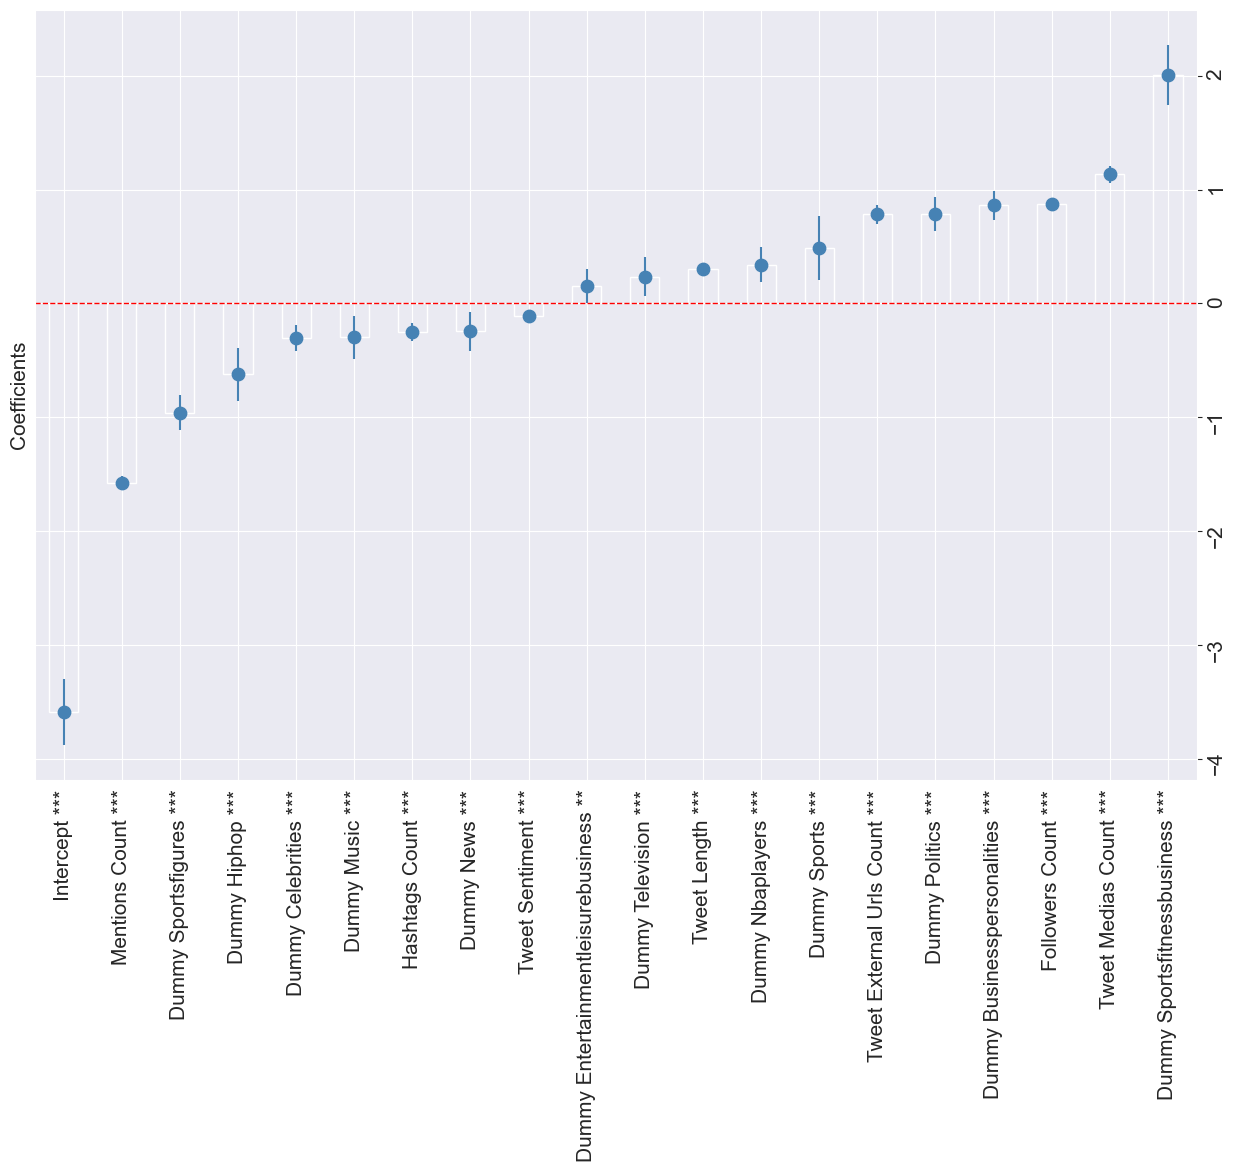

In [18]:
df_name = "regression_american_celebrities"
significant_columns = coefplot(res_reg[3], df_name)

In [63]:
regression_df_pd = pd.read_csv(f'../data/regression/{df_name}.csv')[significant_columns + ['impression_count']]
regression_df_pd = regression_df_pd[regression_df_pd['impression_count'] >= 1e2].copy()
#regression_df_pd = regression_df_pd[regression_df_pd['impression_count'] <= 1e7].copy()

# Perform new regression with significant variables
# Apply log transformation to independent variables
print(np.std(regression_df_pd['impression_count']))
for var in regression_df_pd.columns:
    regression_df_pd[var] = regression_df_pd[var].apply(lambda x: np.log(1+x))

4108270.1123984004


In [60]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# perform regression with splitting into training and validation set and compute mse
def perform_regression_with_split(df, significant_columns):
    # Split into train and validation set
    train, validation = train_test_split(df, test_size=0.2, random_state=42)
    # Perform regression on train set
    res = perform_regression(train, significant_columns)
    # Compute mse on validation set
    y_pred = res.predict(validation[significant_columns])
    y_true = validation['impression_count']
    delta_y = y_pred - y_true
    exp_y_pred = np.exp(y_pred) - 1
    rmse = np.sqrt(np.mean(exp_y_pred**2))
    print(f'RMSE: {rmse}')
    mse = mean_squared_error(y_true, y_pred)
    print(f'MSE: {mse}')
    return res

In [61]:
perform_regression_with_split(regression_df_pd, significant_columns)

RMSE: 525911.7991719206
MSE: 2.6391319328255185


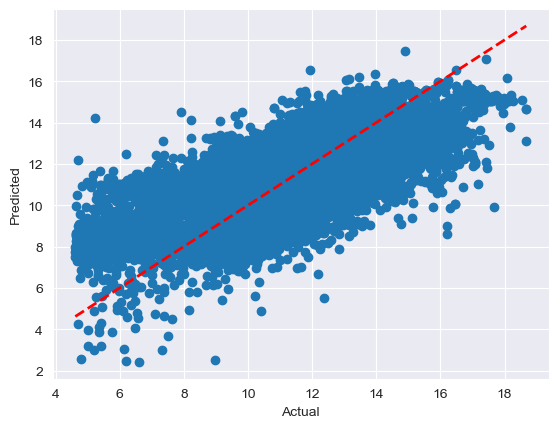

In [22]:
# plot predicted impression count vs actual impression count
def plot_predicted_vs_actual(df, significant_columns):
    res = perform_regression(df, significant_columns)
    y_pred = res.predict(df[significant_columns])
    y_true = df['impression_count']

    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.scatter(y_true, y_pred)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.show()

plot_predicted_vs_actual(regression_df_pd, significant_columns)